In [ ]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 学习任务：

准备好Pytorch环境

了解目标检测的一些基本概念，包括目标框的两种表示形式，IoU等

下载好VOC数据集

学习了解VOC数据集的格式，以及如何用代码读取VOC数据集，构建DataLoader

- 学习资料

  - [3.1 目标检测基本概念](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_1)
  - [3.2 目标检测数据集VOC](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_2)

# 了解目标检测和分类的区别

图像分类：只需要判断输入的图像中是否包含感兴趣物体。

目标检测：需要在识别出图片中目标类别的基础上，还要精确定位到目标的具体位置，并用外接矩形框标出。

- 举个栗子

  - 一个图片中只有一种物体，或包含该物体，我们只想要知道这个图片是哪一种物体，而不关心物体的位置，这是分类任务。

  - 一个图片中有一个或多个物体，我们想知道每个物体在什么位置，这是目标检测任务。

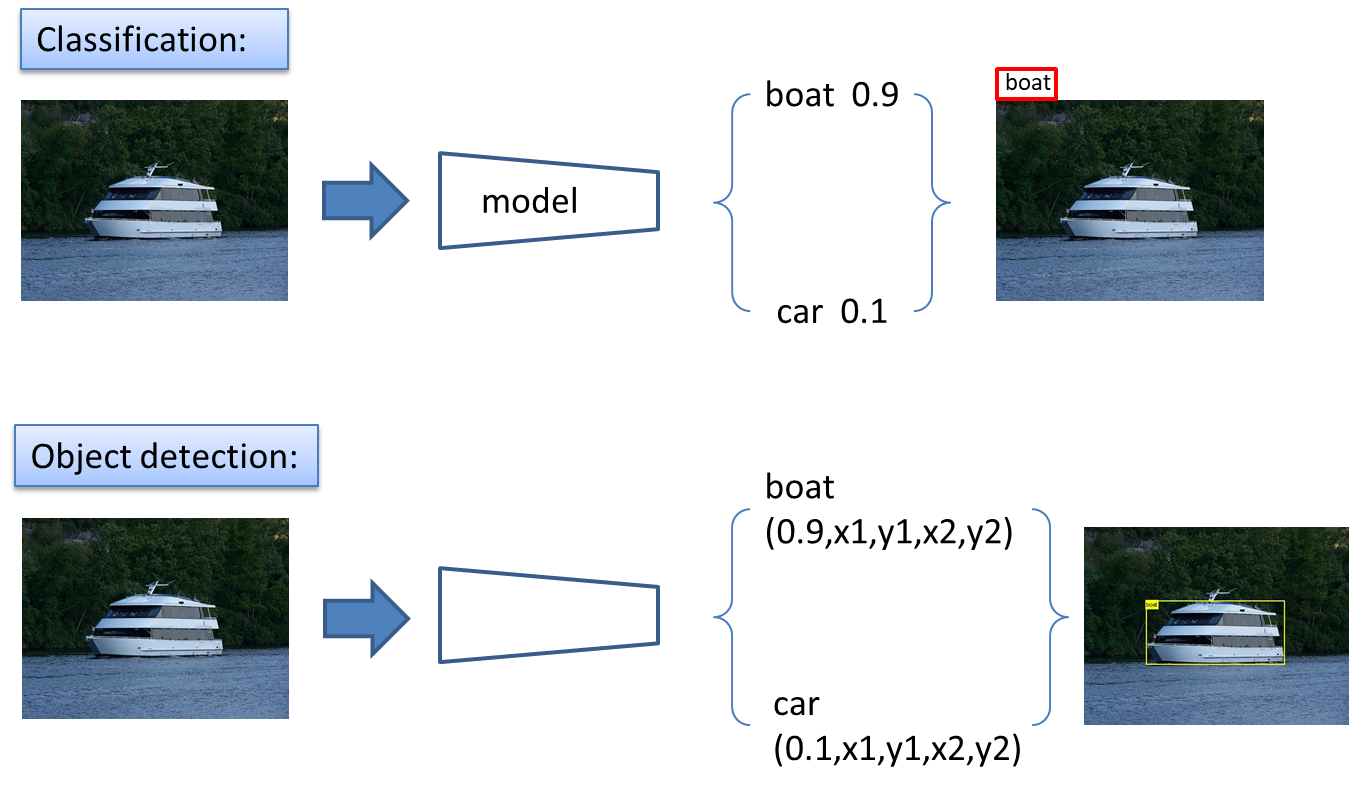

# 目标检测的思路

猜


所谓猜，其实就是通过滑窗的方式，罗列图中各种可能的区域，一个个去试，分别送入到分类网络进行分类得到其类别，同时我们会对当前的边界框进行微调，这样对于图像中每个区域都能得到（class,x1,y1,x2,y2）五个属性，汇总后最终就得到了图中物体的类别和坐标信息。

总结一下我们的这种方案思路：先确立众多候选框，再对候选框进行分类和微调。


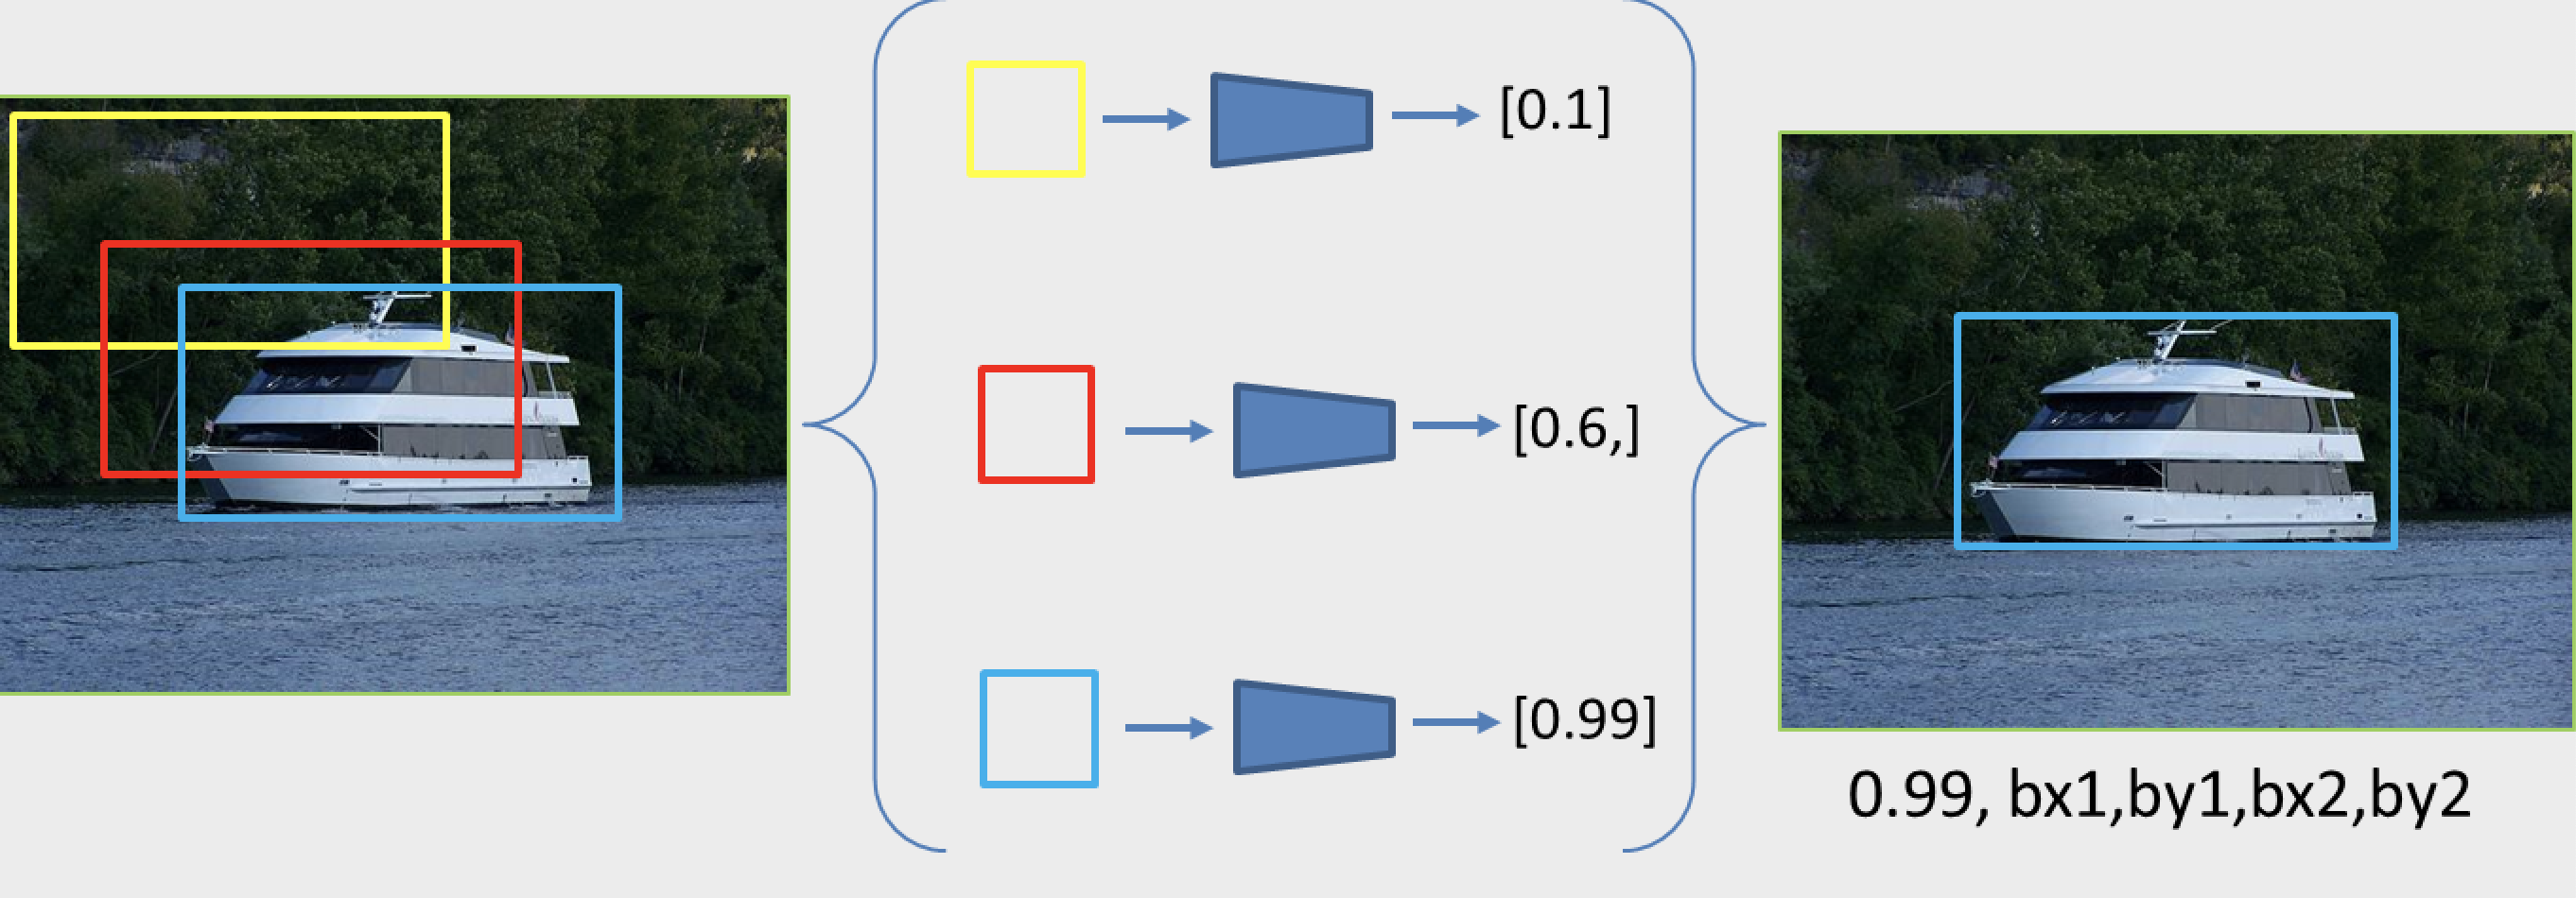

如上图，在待识别图上预设一个框，然后逐像素遍历，就能得到大量候选框（这里仅为示意图，图上只展示了3个框用于说明问题，具体数量由图像大小和预设框大小决定），每个框送入到分类网络分类都有一个得分(代表当前框中有一个船的置信度)，那么得分最高的就代表识别的最准确的框，其位置就是最终要检测的目标的位置。

以上就是最初的基于深度学习的目标检测问题解决思路，RCNN，YOLO，SSD等众多经典网络模型都是沿着这个思路优化发展的。


# 目标框的定义

任何图像任务的训练数据都要包括两项，图片和真实标签信息，通常叫做GT。

图像分类中，标签信息是类别。目标检测的标签信息除了类别label以外，需要同时包含目标的位置信息，也就是目标的外接矩形框bounding box。

用来表达bbox的格式通常有两种，(x1, y1, x2, y2) 和 (c_x, c_y, w, h) ，如图所示：

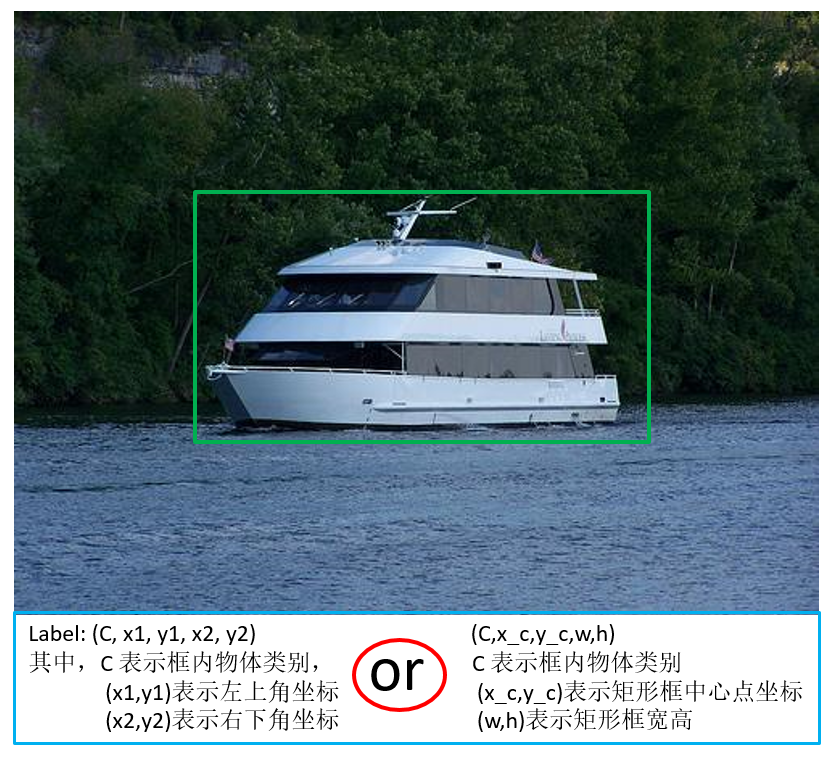

之所以使用两种不同的目标框信息表达格式，是因为两种格式会分别在后续不同场景下更加便于计算。

下面是两种格式转换的代码



In [ ]:
def xy_to_cxcy(box):
  """转换(x1,y1,x2,y2)类型坐标为(cx,cy,w,h)类型坐标"""
  box_cxcy = (
      (box[0] + box[2]) / 2,
      (box[1] + box[3]) / 2,
      box[2] - box[0],
      box[3] - box[1]
      )
  return box_cxcy

xy_to_cxcy((1,1,5,5))

(3.0, 3.0, 4, 4)

In [ ]:
def cxcy_to_xy(box):
  """转换(cx,cy,w,h)类型坐标为(cx,cy,w,h)(x1,y1,x2,y2)类型坐标"""
  box_xy = (
      box[0] - box[2]/2,
      box[1] - box[3]/2,
      box[0] + box[2]/2,
      box[1] + box[3]/2
  )
  return box_xy

cxcy_to_xy((3.0, 3.0, 4, 4))

(1.0, 1.0, 5.0, 5.0)

# 交并比（IoU）

在目标检测任务中，关于IOU的计算贯穿整个模型的训练测试和评价过程，是非常非常重要的一个概念，其目的是用来衡量两个目标框的重叠程度。

IoU的全称是交并比（Intersection over Union），表示两个目标框的交集占其并集的比例。




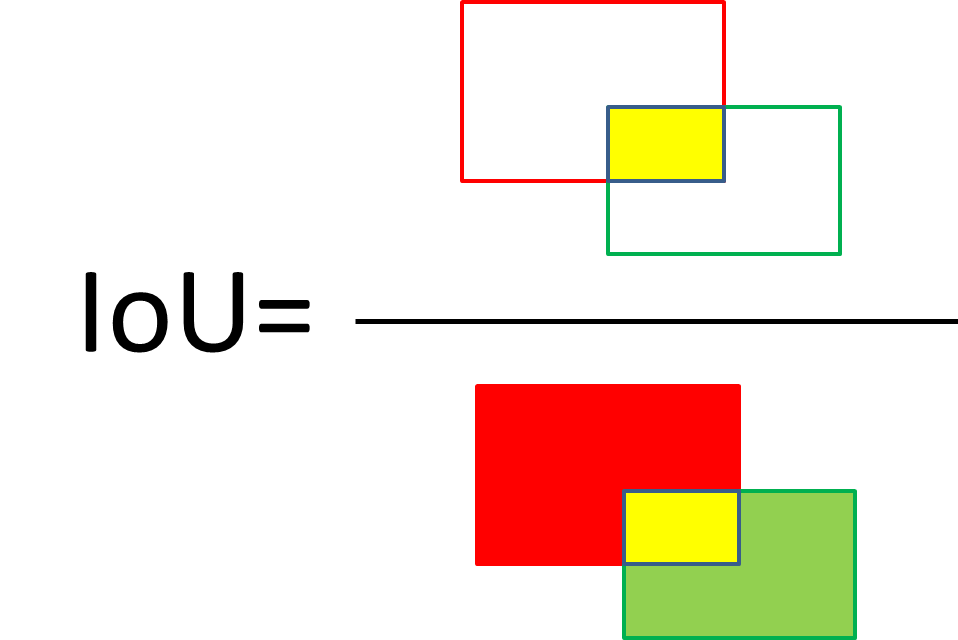

图中可以看到，分子中黄色区域为红bbox和绿bbox的交集，分母中黄+红+绿区域为红bbox和绿bbox的并集，两者之比即为iou。

计算步骤

~~~
1.首先获取两个框的坐标，红框坐标: 左上(red_x1, red_y1), 右下(red_x2, red_y2)，绿框坐标: 左上(green_x1, green_y1)，右下(green_x2, green_y2)
2.计算两个框左上点的坐标最大值:(max(red_x1, green_x1), max(red_y1, green_y1)), 和右下点坐标最小值:(min(red_x2, green_x2), min(red_y2, green_y2))
3.利用2算出的信息计算黄框面积：yellow_area
4.计算红绿框的面积：red_area 和 green_area
5.iou = yellow_area / (red_area + green_area - yellow_area)
~~~

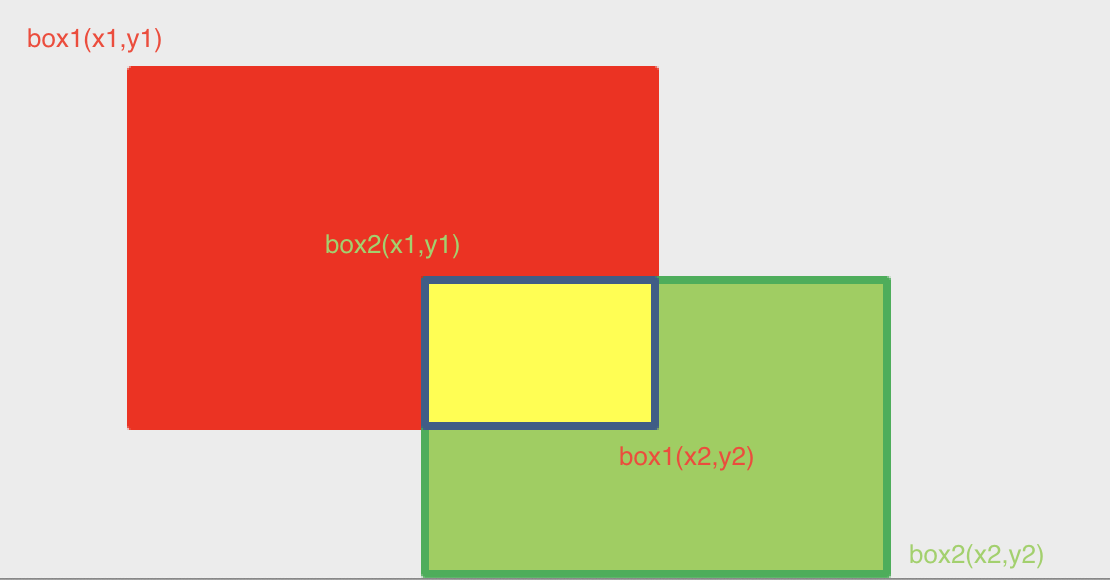

In [ ]:
def cal_iou(box1,box2):
  """
  计算IoU交并比

  input:
    box1: (x_min,y_min,x_max,y_max)
    box2: (x_min,y_min,x_max,y_max)
  output:
    iou
  """
  yellow_left_x = max(box1[0],box2[0]) # 两个图形左上角坐标中最大的则为重叠区域的左上角坐标
  yellow_left_y = max(box1[1],box2[1]) # 两个图形左上角坐标中最大的则为重叠区域的左上角坐标
  yellow_right_x = min(box1[2],box2[2]) # 两个图形右下角最小的则为黄色区域的右下角坐标
  yellow_right_y = min(box1[3],box2[3]) # 两个图形右下角最小的则为黄色区域的右下角坐标

  yellow_area = (yellow_right_x - yellow_left_x) * (yellow_right_y - yellow_left_y)

  red_area = (box1[2] - box1[0]) * (box1[3] - box1[1])

  green_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

  iou = yellow_area / (red_area + green_area - yellow_area)

  return iou

cal_iou((1,2,3,4),(2,3,4,5))

0.14285714285714285

# 认识VOC数据集格式



下载数据集

In [4]:
import torchvision
torchvision.datasets.VOCDetection('.',year='2007',image_set='train',download=True)
torchvision.datasets.VOCDetection('.',year='2012',image_set='train',download=True)

Dataset VOCDetection
    Number of datapoints: 5717
    Root location: .

### 数据集文件目录结构

~~~text
# 目录结构
# VOC2007
.
├── Annotations               # 存放着每张图片相关的标注信息，以xml格式的文件存储
├── ImageSets
│   ├── Layout              # 存放的是train，valid，test和train+val数据集的文件名
│   ├── Main               # 存放的是各个类别所在图片的文件名，比如cow_val，表示valid数据集中，包含有cow类别目标的图片名称。
│   └── Segmentation           # 存放的是实例分割所用train，valid，test和train+val数据集的文件名
├── JPEGImages                # 这个文件夹中存放所有的图片，包括训练验证测试用到的所有图片。
├── SegmentationClass            # 保存的是物体分割后的数据，在物体识别中没有用到
└── SegmentationObject            # 保存的是物体分割后的数据，在物体识别中没有用到
~~~


xml数据格式
```xml
<annotation>
	<folder>VOC2007</folder>
	<filename>009961.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>334575803</flickrid>
	</source>
	<owner>
		<flickrid>dictioncanary</flickrid>
		<name>Lucy</name>
	</owner>
	<size>
		<width>500</width>
		<height>374</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>dog</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>69</xmin>
			<ymin>4</ymin>
			<xmax>392</xmax>
			<ymax>345</ymax>
		</bndbox>
	</object>
</annotation>
```



- filename: 图片名称

- size: 图片宽高

  - width: 宽度

  - height: 高度

  - depth: 表示图片通道数

- object: 表示目标，包含下面两部分内容。

  - name: 类别
  - pose: 姿势
  - truncated: 是否是一个被截断的目标，1表示是，0表示不是
  - difficult: 是否是难以识别的目标,为0表示此目标不是一个难以识别的目标。
  - bbox: 矩形坐标信息可以看到，这里是以[xmin,ymin,xmax,ymax]格式进行标注的，分别表示dog目标的左上角和右下角坐标。

一张图片中有多少需要识别的目标，其xml文件中就有多少个object。


# VOC数据集的dataloader的构建

前期准备

把数据提取到json文件中，后续只用json文件即可创建pytorch的数据集类




- 解析xml文件

In [5]:
# 解析xml
# @file : util.py

import json
import os
import torch
import random
import xml.etree.ElementTree as ET    #解析xml文件所用工具
import torchvision.transforms.functional as FT

#GPU设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label map
#voc_labels为VOC数据集中20类目标的类别名称
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

#创建label_map字典，用于存储类别和类别索引之间的映射关系。比如：{1：'aeroplane'， 2：'bicycle'，......}
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
#VOC数据集默认不含有20类目标中的其中一类的图片的类别为background，类别索引设置为0
label_map['background'] = 0

#将映射关系倒过来，{类别名称：类别索引}
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

#解析xml文件，最终返回这张图片中所有目标的标注框及其类别信息，以及这个目标是否是一个difficult目标
def parse_annotation(annotation_path):
    #解析xml
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()    #存储bbox
    labels = list()    #存储bbox对应的label
    difficulties = list()    #存储bbox对应的difficult信息

    #遍历xml文件中所有的object，前面说了，有多少个object就有多少个目标
    for object in root.iter('object'):
        #提取每个object的difficult、label、bbox信息
        difficult = int(object.find('difficult').text == '1')
        label = object.find('name').text.lower().strip()
        if label not in label_map:
            continue
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        #存储
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    #返回包含图片标注信息的字典
    return {'boxes': boxes, 'labels': labels, 'difficulties': difficulties}


测试解析xml函数

In [11]:
path = './VOCdevkit/VOC2007/Annotations/000005.xml'
parse_annotation(path)

{'boxes': [[262, 210, 323, 338],
  [164, 263, 252, 371],
  [4, 243, 66, 373],
  [240, 193, 294, 298],
  [276, 185, 311, 219]],
 'difficulties': [0, 0, 1, 0, 1],
 'labels': [9, 9, 9, 9, 9]}

- 创建记录训练测试集的json文件

In [15]:
# 分别读取train和valid的图片和xml信息，创建用于训练和测试的json文件
# @file : util.py

def create_data_lists(voc07_path, voc12_path, output_folder):
    """
    Create lists of images, the bounding boxes and labels of the objects in these images, and save these to file.
    :param voc07_path: path to the 'VOC2007' folder
    :param voc12_path: path to the 'VOC2012' folder
    :param output_folder: folder where the JSONs must be saved
    """

    #获取voc2007和voc2012数据集的绝对路径
    voc07_path = os.path.abspath(voc07_path)
    voc12_path = os.path.abspath(voc12_path)

    train_images = list()
    train_objects = list()
    n_objects = 0

    # Training data
    for path in [voc07_path, voc12_path]:

        # Find IDs of images in training data
        #获取训练所用的train和val数据的图片id
        with open(os.path.join(path, 'ImageSets/Main/trainval.txt')) as f:
            ids = f.read().splitlines()

        #根据图片id，解析图片的xml文件，获取标注信息
        for id in ids:
            # Parse annotation's XML file
            objects = parse_annotation(os.path.join(path, 'Annotations', id + '.xml'))
            if len(objects['boxes']) == 0:    #如果没有目标则跳过
                continue
            n_objects += len(objects)        #统计目标总数
            train_objects.append(objects)    #存储每张图片的标注信息到列表train_objects
            train_images.append(os.path.join(path, 'JPEGImages', id + '.jpg'))    #存储每张图片的路径到列表train_images，用于读取图片

    assert len(train_objects) == len(train_images)        #检查图片数量和标注信息量是否相等，相等才继续执行程序

    # Save to file
    #将训练数据的图片路径，标注信息，类别映射信息，分别保存为json文件
    with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, 'label_map.json'), 'w') as j:
        json.dump(label_map, j)  # save label map too

    print('\nThere are %d training images containing a total of %d objects. Files have been saved to %s.' % (
        len(train_images), n_objects, os.path.abspath(output_folder)))


    #与Train data一样，目的是将测试数据的图片路径，标注信息，类别映射信息，分别保存为json文件，参考上面的注释理解
    # Test data
    test_images = list()
    test_objects = list()
    n_objects = 0

    # Find IDs of images in the test data
    with open(os.path.join(voc07_path, 'ImageSets/Main/val.txt')) as f:
        ids = f.read().splitlines()

    for id in ids:
        # Parse annotation's XML file
        objects = parse_annotation(os.path.join(voc07_path, 'Annotations', id + '.xml'))
        if len(objects) == 0:
            continue
        test_objects.append(objects)
        n_objects += len(objects)
        test_images.append(os.path.join(voc07_path, 'JPEGImages', id + '.jpg'))

    assert len(test_objects) == len(test_images)

    # Save to file
    with open(os.path.join(output_folder, 'TEST_images.json'), 'w') as j:
        json.dump(test_images, j)
    with open(os.path.join(output_folder, 'TEST_objects.json'), 'w') as j:
        json.dump(test_objects, j)

    print('\nThere are %d test images containing a total of %d objects. Files have been saved to %s.' % (
        len(test_images), n_objects, os.path.abspath(output_folder)))


In [16]:
create_data_lists(
    voc07_path='./VOCdevkit/VOC2007',
    voc12_path='./VOCdevkit/VOC2012',
    output_folder='./VOCdevkit')


There are 16551 training images containing a total of 49653 objects. Files have been saved to /content/VOCdevkit.

There are 2510 test images containing a total of 7530 objects. Files have been saved to /content/VOCdevkit.


## pytorch dataset数据集构建


In [17]:
# 数据增强
"""transform操作是训练模型中一项非常重要的工作，其中不仅包含数据增强以提升模型性能的相关操作，也包含如数据类型转换(PIL to Tensor)、归一化(Normalize)这些必要操作。"""
import json
import os
import torch
import random
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

"""
可以看到，transform分为TRAIN和TEST两种模式，以本实验为例：

在TRAIN时进行的transform有：
1.以随机顺序改变图片亮度，对比度，饱和度和色相，每种都有50％的概率被执行。photometric_distort
2.扩大目标，expand
3.随机裁剪图片，random_crop
4.0.5的概率进行图片翻转，flip
*注意：a. 第一种transform属于像素级别的图像增强，目标相对于图片的位置没有改变，因此bbox坐标不需要变化。
         但是2，3，4，5都属于图片的几何变化，目标相对于图片的位置被改变，因此bbox坐标要进行相应变化。

在TRAIN和TEST时都要进行的transform有：
1.统一图像大小到(224,224)，resize
2.PIL to Tensor
3.归一化，FT.normalize()

注1: resize也是一种几何变化，要知道应用数据增强策略时，哪些属于几何变化，哪些属于像素变化
注2: PIL to Tensor操作，normalize操作必须执行
"""

def transform(image, boxes, labels, difficulties, split):
    """
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """

    #在训练和测试时使用的transform策略往往不完全相同，所以需要split变量指明是TRAIN还是TEST时的transform方法
    assert split in {'TRAIN', 'TEST'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html

    #为了防止由于图片之间像素差异过大而导致的训练不稳定问题，图片在送入网络训练之间需要进行归一化
    #对所有图片各通道求mean和std来获得
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    new_difficulties = difficulties

    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, boxes, filler=mean)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,new_difficulties)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (224, 224) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(224, 224))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels, new_difficulties


In [18]:
"""PascalVOCDataset具体实现过程"""
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image


class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    #初始化相关变量
    #读取images和objects标注信息
    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()    #保证输入为纯大写字母，便于匹配{'TRAIN', 'TEST'}

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    #循环读取image及对应objects
    #对读取的image及objects进行tranform操作（数据增广）
    #返回PIL格式图像，标注框，标注框对应的类别索引，对应的difficult标志(True or False)
    def __getitem__(self, i):
        # Read image
        #*需要注意，在pytorch中，图像的读取要使用Image.open()读取成PIL格式，不能使用opencv
        #*由于Image.open()读取的图片是四通道的(RGBA)，因此需要.convert('RGB')转换为RGB通道
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        #如果self.keep_difficult为False,即不保留difficult标志为True的目标
        #那么这里将对应的目标删去
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        #对读取的图片应用transform
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    #获取图片的总数，用于计算batch数
    def __len__(self):
        return len(self.images)

    #我们知道，我们输入到网络中训练的数据通常是一个batch一起输入，而通过__getitem__我们只读取了一张图片及其objects信息
    #如何将读取的一张张图片及其object信息整合成batch的形式呢？
    #collate_fn就是做这个事情，
    #对于一个batch的images，collate_fn通过torch.stack()将其整合成4维tensor，对应的objects信息分别用一个list存储
    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        #(3,224,224) -> (N,3,224,224)
        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 224, 224), 3 lists of N tensors each

实例化数据集

In [19]:
train_dataset = PascalVOCDataset(
    data_folder,
    split='train',
    keep_difficult=keep_difficult
    )

## pytorch dataloader数据读取器构建


实例化dataloader

In [ ]:
#参数说明：
#在train时一般设置shufle=True打乱数据顺序，增强模型的鲁棒性
#num_worker表示读取数据时的线程数，一般根据自己设备配置确定（如果是windows系统，建议设默认值0，防止出错）
#pin_memory，在计算机内存充足的时候设置为True可以加快内存中的tensor转换到GPU的速度，具体原因可以百度哈~
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=train_dataset.collate_fn, 
    num_workers=workers,
    pin_memory=True)

# 小结

- 认识了voc数据集格式
- 学习pytorch数据集训练前需要的数据预处理
- 学习了数据集(dataset)的构建
- 学习了数据读取器(dataloader)的构建